In [114]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from skimage.transform import resize
from IPython.display import display, HTML
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [115]:
#Loading the dataset from sklearn dataset library
from sklearn.datasets import fetch_lfw_people

In [116]:
#Only include images of individuals with at least 70 images, and resize the image to 40% of its original size
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

In [117]:
print(lfw_people.keys()) #This will view the keys in the dataset
print("Number of images in LFW Dataset :", len(fetch_lfw_people().data)) #This will confirm that there are 13233 images in the dataset
print("Number of Faces in variable lfw_people with above 70 Images :", len(lfw_people.data)) #This will confirm the number of faces having a minimum of 70 images in our lfw_people variable

dict_keys(['data', 'images', 'target', 'target_names', 'DESCR'])
Number of images in LFW Dataset : 13233
Number of Faces in variable lfw_people with above 70 Images : 1288


In [118]:
#Store images to variable name X
X = lfw_people.images
#Store target to variable name Y. Target is the file name of the image which is linked to target_names key to derive the actual name of the person
y = lfw_people.target

In [119]:
print(len(fetch_lfw_people().target_names)) #Total number of persons in dataset
print(len(lfw_people.target_names)) #Total number of persons with images above 70 in dataset
print(lfw_people.target_names) #To confirm the names of persons with images above 70 in dataset

5749
7
['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']


In [120]:
X_resized = []                                                      # Creating an empty list to store resized images
for img in X:                                                       # Looping through each image in the original X dataset
    img_resized = resize(img, (64, 64), anti_aliasing=True)         # Resize the image to 64x64 using anti-aliasing from skimage.transform library
    img_resized = np.repeat(img_resized[..., np.newaxis], 3, -1)    # Add a new axis to the image and repeat it 3 times along the last axis to convert it to RGB format
    X_resized.append(img_resized)                                   # Add the resized and converted image to the list of resized images

In [121]:
# Convert the list to a numpy array
X = np.array(X_resized)

In [122]:
# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=57, stratify = y)

In [123]:
# Checking the shapes and also ensuring that the number of images and labels are equal to ensure that the data is loaded perfectly
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(1030, 64, 64, 3) (1030,)
(258, 64, 64, 3) (258,)


In [124]:
#PLOTING SOME RANDOM IMAGES IN THE TRAINING DATA AND SHOWING THEIR NAMES
# define the number of images to plot
num_images_to_plot = 8
target_names = lfw_people.target_names

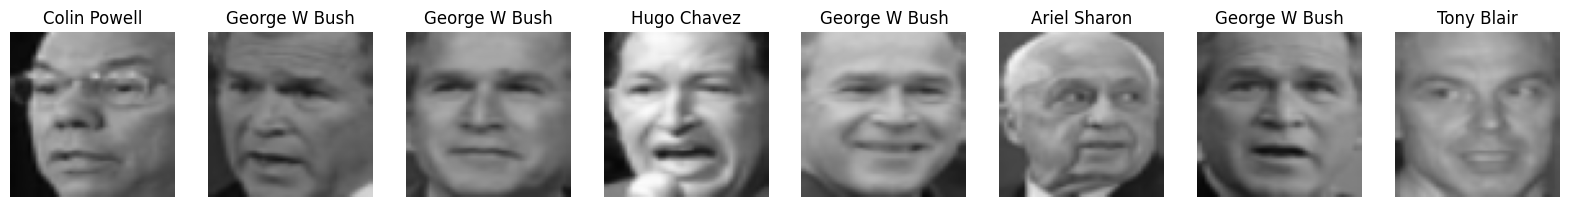

In [125]:
# randomly selecting some images and their labels from the training data
indices = np.random.choice(len(X_train), size=num_images_to_plot, replace=False)
images = X_train[indices]
labels = y_train[indices]

# mapping the numerical class labels to their corresponding names
labelname = [target_names[label] for label in labels]

# creating a subplot with the selected images and their labels
fig, axs = plt.subplots(1, num_images_to_plot, figsize=(20, 5))
for i in range(num_images_to_plot):
    axs[i].imshow(images[i])
    axs[i].set_title(labelname[i])
    axs[i].axis('off')

# showing the plot
plt.show()

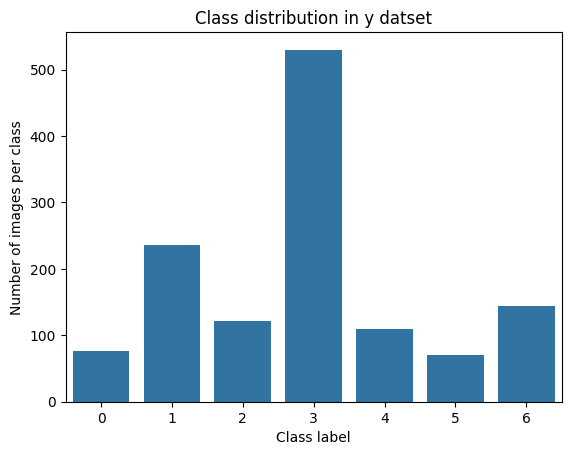

In [126]:
# creating a countplot to check the number of images in each class i.e. visualizing the class distribution
sns.countplot(x=y)
# add labels and title to the plot
plt.xlabel('Class label')
plt.ylabel('Number of images per class')
plt.title('Class distribution in y datset')

# show the plot
plt.show()

In [127]:
# Creating a list to map the numerical class labels to their corresponding names
names_of_faces = [target_names[label] for label in y]
result = pd.DataFrame(names_of_faces, columns=['Names_of_persons'])
result['Image_Count'] = result.groupby('Names_of_persons')['Names_of_persons'].transform('count')

# Appending the Class Number to DataFrame
result['ClassNumber'] = y

# Drop duplicate rows and reset index
result_df = result.drop_duplicates().reset_index(drop=True)

#sorting result bythe ClassNumber
result_df = result_df.sort_values(by='ClassNumber')

# Displaying the result of each class with their names and showing the number of images they have.
display(HTML(result_df.to_html(index=False)))

Names_of_persons,Image_Count,ClassNumber
Ariel Sharon,77,0
Colin Powell,236,1
Donald Rumsfeld,121,2
George W Bush,530,3
Gerhard Schroeder,109,4
Hugo Chavez,71,5
Tony Blair,144,6


I observed that the data is not balanced, there is need to balance the data distribution to have equal number of images. This will help avoid overfitting


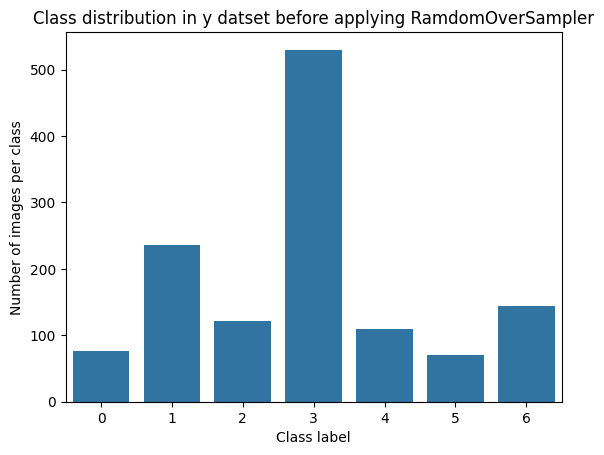

In [128]:
#plotting class distribution before RandomOverSamper Data augmentation technique
# creating a countplot to check the number of images in each class i.e. visualizing the class distribution
sns.countplot(x=y)

# add labels and title to the plot
plt.xlabel('Class label')
plt.ylabel('Number of images per class')
plt.title('Class distribution in y datset before applying RamdomOverSampler')

# show the plot
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


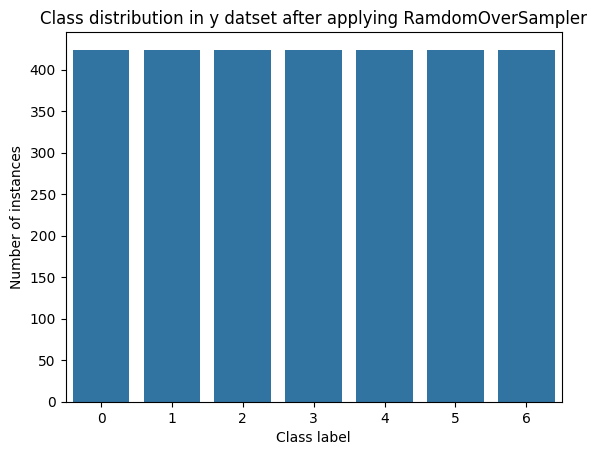

In [129]:
  #Applying the Ramdom Over Sampler Technique to balance the class distribution of the dataset
# Creating a RandomOverSampler object to resample the images
ros = RandomOverSampler(random_state=0)

# Reshaping the image data to 2D arrays for oversampling
X_train_2d = X_train.reshape(X_train.shape[0], -1)

# Fitting the randomoversampler
X_resampled, y_resampled = ros.fit_resample(X_train_2d, y_train)

# Reshaping the resampled data back to 3D image arrays
X_resampled = X_resampled.reshape(-1, X_train.shape[1], X_train.shape[2], X_train.shape[3])

# creating a countplot to check the number of images in each class after balancingthe class distribution
sns.countplot(x=y_resampled)

# add labels and title to the plot
plt.xlabel('Class label')
plt.ylabel('Number of instances')
plt.title('Class distribution in y datset after applying RamdomOverSampler')

# show the plot
plt.show()

In [130]:
# Creating a list to map the numerical class labels to their corresponding names
names_of_faces = [target_names[label] for label in y_resampled]

result = pd.DataFrame(names_of_faces, columns=['Names_of_persons'])
result['Image_Count'] = result.groupby('Names_of_persons')['Names_of_persons'].transform('count')

# Appending the Class Number to DataFrame
result['ClassNumber'] = y_resampled

# Drop duplicate rows and reset index
result_df = result.drop_duplicates().reset_index(drop=True)

#sorting result bythe ClassNumber
result_df = result_df.sort_values(by='ClassNumber')

# Displaying the result of each class with their names and showing the number of images they have.
display(HTML(result_df.to_html(index=False)))

Names_of_persons,Image_Count,ClassNumber
Ariel Sharon,424,0
Colin Powell,424,1
Donald Rumsfeld,424,2
George W Bush,424,3
Gerhard Schroeder,424,4
Hugo Chavez,424,5
Tony Blair,424,6


(64, 64, 3)
3


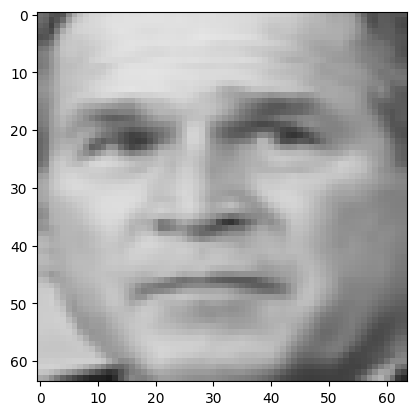

In [131]:
# storing the resampled values in the train variables
X_train, y_train = X_resampled, y_resampled

#confirming image size and target for index 700. Class 3 is labelled as Geroge Bush, so image corresponds
plt.imshow(X_train[700])
print(X_train[700].shape)
print(y_train[700])

From the subplot created earlier displaying random images, I observed that some of the images are bright in color whereas some are dim in color so we need to change the pixel intensity values such that they have simialr brightness. I will apply grayscale conversion, histogram equalisation and pixel normalisation on this image to test result and then apply to all image.

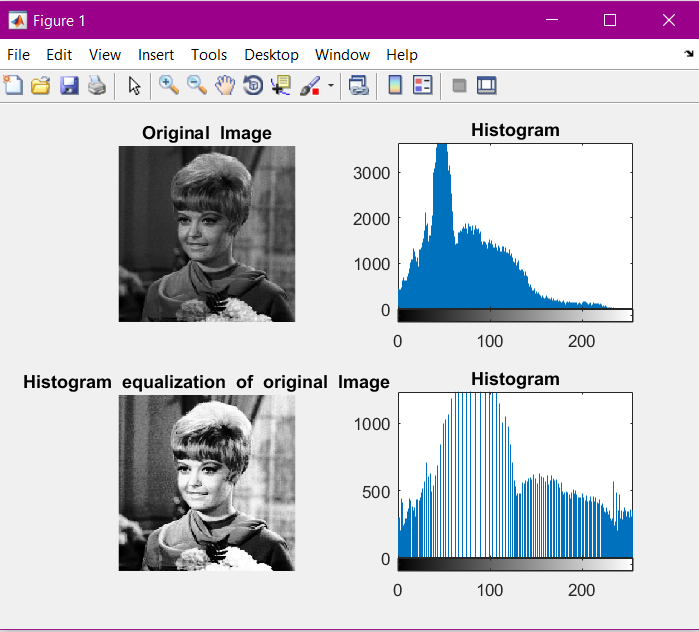

(64, 64)
(64, 64)
(64, 64)


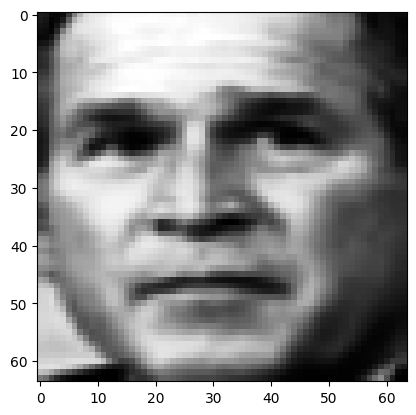

In [132]:
# grayscale conversion on image with index 700
gray_img700 = cv2.cvtColor(X_train[700],cv2.COLOR_BGR2GRAY)
gray_img700 = np.uint8(cv2.normalize(gray_img700, None, 0, 255, cv2.NORM_MINMAX))
plt.imshow(gray_img700, cmap="gray")
print(gray_img700.shape)

# Testing Histogram equalization on image with index 700
hist_eq_img700 = cv2.equalizeHist(gray_img700)
plt.imshow(hist_eq_img700, cmap="gray")
print(hist_eq_img700.shape)

# pixel normalization on image in index 700
normalized_img700 = hist_eq_img700/255.0
plt.imshow(normalized_img700, cmap="gray")
print(normalized_img700.shape)


From the subplot created earlier, which display randomed images in the dataset. I observed that some of the images are bright in color whereas some are dim in color so we need to change the pixel intensity values such that they have simialr brightness. I will create a function named preprocessing  to include carry out grayscale conversion, histogram equalization and pixel normalization on all image in traning and test dataset

[link text](https://)

In [133]:
def preprocessing(img):
  img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  img = np.uint8(cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX))
  img = cv2.equalizeHist(img)
  return img

In [134]:
# using the numpy array function with map() to apply prepeocessing on the training and test datasets
X_train = np.array(list(map(preprocessing, X_train)))
X_test = np.array(list(map(preprocessing, X_test)))

(64, 64)


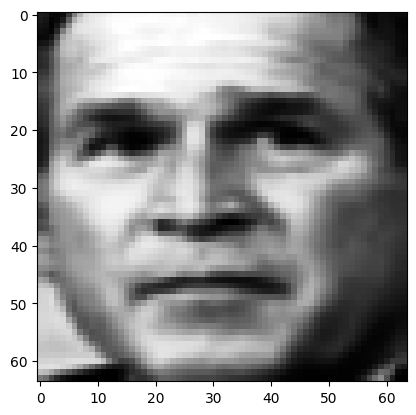

In [135]:
#confirming with image inindex 700 that processing have been applied
plt.imshow(X_train[700], cmap="gray")
print(X_train[700].shape) #confirming shape of image

In [136]:
#CNN odel require a third shape of the image known as depth channel
X_train.shape, X_test.shape

# adding depth channel to the traning and test dataset
X_train = X_train.reshape(X_train.shape[0], 64, 64, 1)
X_test = X_test.reshape(X_test.shape[0], 64, 64,1)

#Confirming the depth channel is added
X_train.shape, X_test.shape

pd.DataFrame(y_train).value_counts()
# using to_categorical to binary encode the target label in training and test datatset
y_train = to_categorical(y_train, 7)
y_test = to_categorical(y_test, 7)

# set the number of classes
no_of_class_distribution = 7


In [137]:
# define the LeNet-5 architecture
def lenet_architecture():
  # create a sequential model
  model = Sequential()
  # adding a convolutional layer 1 with 30 filters and a 5x5 kernel size
  model.add(Conv2D(30, (5, 5), input_shape=(64, 64, 1), activation='relu'))
  # add a max pooling layer 1 with a 2x2 pool size
  model.add(MaxPooling2D(pool_size=(2, 2)))
  # adding a second convolutional layer 2 with 15 filters and a 3x3 kernel size
  model.add(Conv2D(15, (3, 3), activation='relu'))
  # adding a second max pooling layer 2  with a 2x2 pool size
  model.add(MaxPooling2D(pool_size=(2, 2)))
  # flatten the output of the convolutional layers
  model.add(Flatten())
  # adding a fully connected layer 1 with 500 units and a ReLU activation function
  model.add(Dense(500, activation='relu'))
  # adding a dropout layer to prevent overfitting
  model.add(Dropout(0.5))
  # adding a final fully connected layer 2 with num_classes units and a softmax activation function. only 7 classes of image available.
  model.add(Dense(no_of_class_distribution, activation='softmax'))
  # compiling the model using Adam optimizer, categorical crossentropy loss function, and accuracy as the metric
  model.compile(Adam(learning_rate = 0.01), loss='categorical_crossentropy', metrics=['accuracy'])
  return model


my_lenet_model = lenet_architecture()

my_lenet_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 60, 60, 30)          │             780 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 30, 30, 30)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 28, 28, 15)          │           4,065 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 14, 14, 15)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 2940)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 500)                 │       1,470,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 7)                   │           3,507 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,478,852 (5.64 MB)

 Trainable params: 1,478,852 (5.64 MB)

 Non-trainable params: 0 (0.00 B)

Building the lenet 5 architecture.


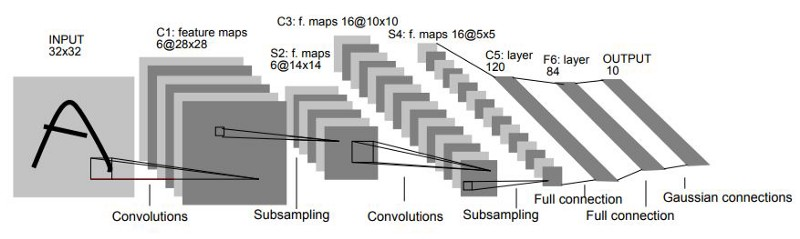

In [138]:
# fitting the model on train data and validating the model on test data
history = my_lenet_model.fit(X_train,y_train,epochs=10, validation_data=(X_test,y_test), batch_size = 32, shuffle = 1, verbose = 1)


Epoch 1/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.1343 - loss: 26.4759 - val_accuracy: 0.0853 - val_loss: 1.9458
Epoch 2/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1267 - loss: 1.9486 - val_accuracy: 0.0543 - val_loss: 1.9431
Epoch 3/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1443 - loss: 1.9468 - val_accuracy: 0.0930 - val_loss: 1.9564
Epoch 4/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1340 - loss: 1.9482 - val_accuracy: 0.1822 - val_loss: 1.9423
Epoch 5/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1352 - loss: 1.9482 - val_accuracy: 0.1124 - val_loss: 1.9466
Epoch 6/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1409 - loss: 1.9479 - val_accuracy: 0.0853 - val_loss: 1.9481
Epoch 7/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1344 - loss: 1.9467 - val_accuracy: 0.0543 - val_loss: 1.9434
Epoch 8/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1519 - loss: 1.9463 - val_accuracy: 0.1124 - val_los

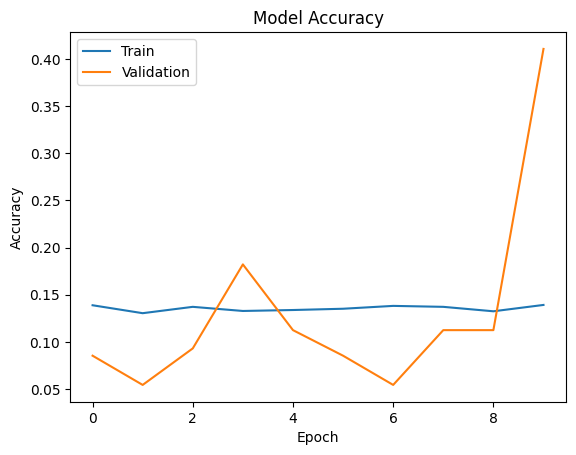

In [139]:
# Below code plots the accuracy of the model during training and validation
plt.plot(history.history['accuracy'])        # Plot the training accuracy
plt.plot(history.history['val_accuracy'])    # Plot the validation accuracy
plt.title('Model Accuracy')                  # Set the title of the plot to 'Model Accuracy'
plt.ylabel('Accuracy')                       # Set the y-axis label to 'Accuracy'
plt.xlabel('Epoch')                          # Set the x-axis label to 'Epoch'
plt.legend(['Train', 'Validation'], loc='upper left')   # Add a legend to the plot to distinguish between the training and validation accuracy
plt.show()                                   # Show the plot

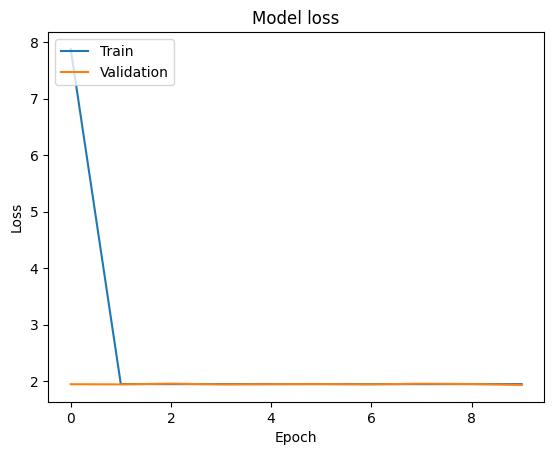

In [140]:
# This line plots the training loss over epochs.
plt.plot(history.history['loss'])
# This line plots the validation loss over epochs.
plt.plot(history.history['val_loss'])
# This line sets the title of the plot.
plt.title('Model loss')
# This line sets the label for the y-axis.
plt.ylabel('Loss')
# This line sets the label for the x-axis.
plt.xlabel('Epoch')
# This line adds a legend to the plot, with labels for the two lines.
plt.legend(['Train', 'Validation'], loc='upper left')
# This line displays the plot.
plt.show()

In [141]:
# Evaluating the performance of a trained Lenet model on a test dataset and retrieve the overall score and accuracy metrics.
# The score represents the error rate of the model on the test dataset.
# The accuracy represents the proportion of correct predictions made by the model on the test set.
score, accuracy = my_lenet_model.evaluate(X_test, y_test, verbose=1)

# Print the score and accuracy metrics to the console
print("Score:", score)
print("Accuracy:", accuracy)

# Define the number of classes for classification
num_classes = 7

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4018 - loss: 1.9344 
Score: 1.9335650205612183
Accuracy: 0.41085270047187805


The LENET 5 Architecture gave a poor accuracy, I will now modify the architecture by adding additional convolutional layers by adding more pooling layer and also adjusting the filters, kernal sizes and drop outs

In [142]:
def modified_lenet_architecture():
  model = Sequential()
  # Add the first convolutional layer with 60 filters, a 5x5 kernel, and ReLU activation function
  # The input shape is 64x64x1, representing grayscale images of size 64x64 pixels
  model.add(Conv2D(60, (5, 5), input_shape=(64, 64, 1), activation='relu'))
  # Add a second convolutional layer with 60 filters and a 5x5 kernel, followed by a ReLU activation function
  model.add(Conv2D(50, (5, 5), activation='relu'))
  # Add a max pooling layer with a pool size of 2x2 to downsample the feature maps
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.3))
  # Add a third convolutional layer with 30 filters and a 3x3 kernel, followed by a ReLU activation function
  model.add(Conv2D(30, (3, 3), activation='relu'))
  # Add a fourth convolutional layer with 30 filters and a 3x3 kernel, followed by a ReLU activation function
  model.add(Conv2D(30, (3, 3), activation='relu'))
  # Add another max pooling layer with a pool size of 2x2 to further downsample the feature maps
  model.add(MaxPooling2D(pool_size=(2, 2)))
  # Add a dropout layer to prevent overfitting by randomly setting 60% of the input units to 0 during training
  model.add(Dropout(0.6))
  # Flatten the output from the previous layer into a 1D array
  model.add(Flatten())
  # Add a fully connected (dense) layer with 128 units and a ReLU activation function
  model.add(Dense(128, activation='relu'))
  # Add another dropout layer to further prevent overfitting by randomly setting 50% of the input units to 0 during training
  model.add(Dropout(0.6))
  # Add the output layer with num_classes units and a softmax activation function for multiclass classification
  model.add(Dense(num_classes, activation='softmax'))
  # Compile the model with the Adam optimizer, a learning rate of 0.001, categorical crossentropy loss function, and accuracy metric
  model.compile(Adam(learning_rate = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  # Return the compiled model
  return model

# calling the modified model
modified_lenet_model = modified_lenet_architecture()

# showing the modified model summary
modified_lenet_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)                   │ (None, 60, 60, 60)          │           1,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 56, 56, 50)          │          75,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 28, 28, 50)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 28, 28, 50)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 26, 26, 30)          │          13,530 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 24, 24, 30)          │           8,130 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 12, 12, 30)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 12, 12, 30)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 4320)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │         553,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 652,261 (2.49 MB)

 Trainable params: 652,261 (2.49 MB)

 Non-trainable params: 0 (0.00 B)

In [143]:
#Re-training the model on the training dataset and validation the result on the test dataset
history1 = modified_lenet_model.fit(X_train,y_train,epochs=20, validation_data=(X_test,y_test), batch_size = 32, shuffle = 1, verbose = 1)


Epoch 1/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 88ms/step - accuracy: 0.1473 - loss: 6.9239 - val_accuracy: 0.1705 - val_loss: 1.9390
Epoch 2/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.1741 - loss: 1.9217 - val_accuracy: 0.5349 - val_loss: 1.7183
Epoch 3/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3337 - loss: 1.6910 - val_accuracy: 0.6589 - val_loss: 1.2092
Epoch 4/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5367 - loss: 1.3087 - val_accuracy: 0.7984 - val_loss: 0.8116
Epoch 5/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6312 - loss: 1.0374 - val_accuracy: 0.7868 - val_loss: 0.7490
Epoch 6/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7013 - loss: 0.8433 - val_accuracy: 0.8333 - val_loss: 0.7196
Epoch 7/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7502 - loss: 0.7175 - val_accuracy: 0.8411 - val_loss: 0.5927
Epoch 8/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7843 - loss: 0.5820 - val_accuracy: 0.8295 - 

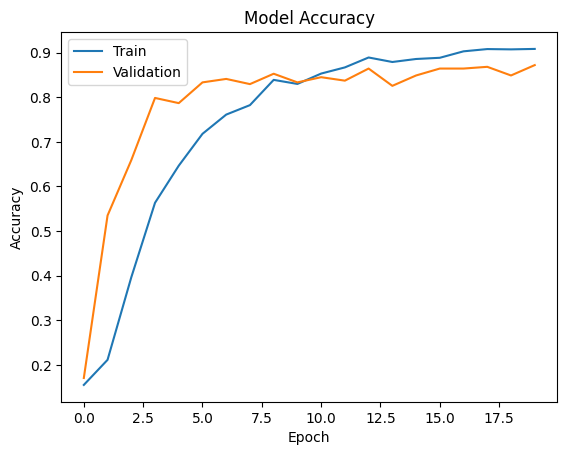

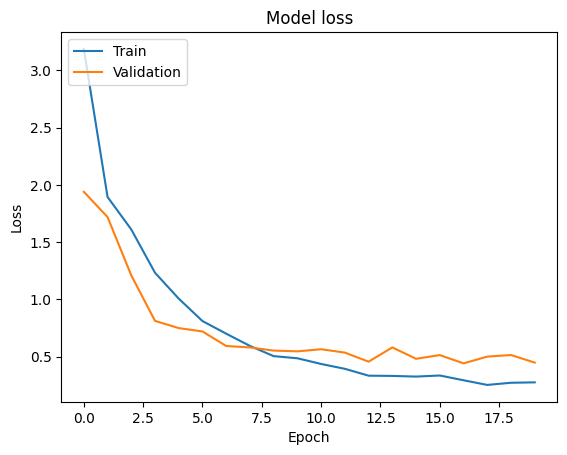

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8723 - loss: 0.4234 
Score: 0.44768476486206055
Accuracy: 0.8720930218696594


In [144]:

plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluating the performance of a modified LeNet model on a test set
# The model takes in the test input data (X_test) and expected output labels (y_test) as inputs.
# The verbose=1 argument specifies that progress updates should be printed during evaluation.
score, accuracy = modified_lenet_model.evaluate(X_test, y_test, verbose=1)
# Print the score and accuracy of the model's performance on the test dataset.
# The score represents the error rate of the model on the test dataset.
# The accuracy represents the proportion of correct predictions made by the model on the test set.
print("Score:", score)
print("Accuracy:", accuracy)

In [145]:
# This line uses the modified LeNet model to predict the classes of the test data.
y_pred = modified_lenet_model.predict(X_test)
# This line prints a report of the classification performance of the model.
# The report includes metrics such as precision, recall, and F1 score.
# The np.argmax function is used to convert the one-hot encoded labels to integer labels.
# The target_names parameter specifies the names of the classes in the dataset.
print(classification_report(np.argmax(y_test,axis=1),np.argmax(y_pred,axis=1), target_names=lfw_people.target_names))


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
                   precision    recall  f1-score   support

     Ariel Sharon       0.82      0.88      0.85        16
     Colin Powell       0.91      0.89      0.90        47
  Donald Rumsfeld       0.75      0.88      0.81        24
    George W Bush       0.96      0.94      0.95       106
Gerhard Schroeder       0.81      0.59      0.68        22
      Hugo Chavez       0.71      0.86      0.77        14
       Tony Blair       0.77      0.79      0.78        29

         accuracy                           0.87       258
        macro avg       0.82      0.83      0.82       258
     weighted avg       0.88      0.87      0.87       258



In [146]:
y_pred = modified_lenet_model.predict(X_test)

# The np.argmax() function returns the indices of the maximum values along a given axis.
# In this case, it's being used to find the predicted class for each example in y_pred.
y_pred = np.argmax(y_pred, axis=1)

# Similarly, np.argmax() is being used here to find the true class for each example in y_test.
y_test_arg = np.argmax(y_test, axis=1)



9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


<Figure size 1000x1000 with 0 Axes>

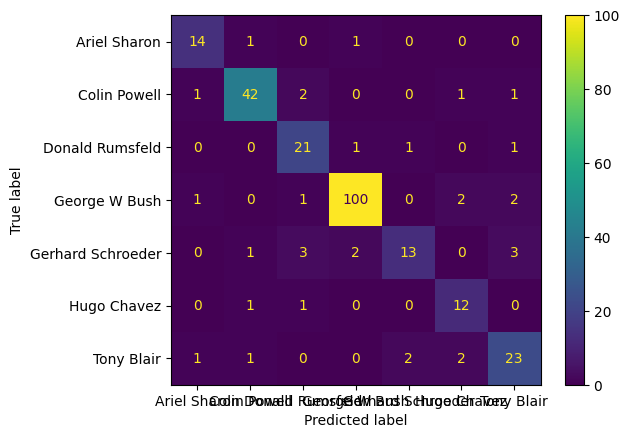

In [147]:
# Plotting a confusion matrix for the model


# Compute the confusion matrix based on the true labels and predicted labels
cm = confusion_matrix(y_test_arg, y_pred)
# Create a ConfusionMatrixDisplay object to display the confusion matrix
# Set the display labels to be the target names of the LFW dataset
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=lfw_people.target_names)
# Set the figure size to 10x10 inches
plt.figure(figsize =(10, 10))
# Plot the confusion matrix using the ConfusionMatrixDisplay object
disp.plot()
# Display the plot
plt.show()


In [148]:
names = lfw_people.target_names
names

array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Hugo Chavez', 'Tony Blair'], dtype='<U17')

(64, 64)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
predicted name: ['George W Bush']


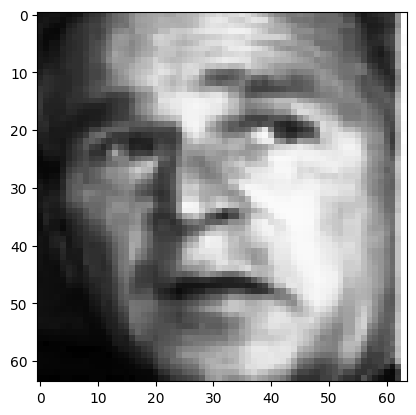

In [149]:
#added a sample external image
img = cv2.imread("george_bush.jpg")
# getting image as array
img = np.asarray(img)
# resizing the image
img = cv2.resize(img, (64, 64))
# applying preprocessing on it
img = preprocessing(img)
# plotting the image
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
# adding the depth so that it can be given as input to model
img = img.reshape(1, 64, 64, 1)
# predicting the class label
print("predicted name: "+ str(names[np.argmax(modified_lenet_model.predict(img), axis=1)]))